<a href="https://colab.research.google.com/github/Temple2001/ML_practice/blob/main/codes/U_net_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [42]:
# Generators
def image_generator(files, batch_size=32, sz=(256,256)):

    while True:

        # batch 랜덤화
        batch = np.random.choice(files, size=batch_size)

        batch_x = []
        batch_y = []

        for f in batch:

            # mask 생성
            mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
            mask = np.array(mask.resize(sz))

            # mask 전처리
            # 배경이 아닌 부분은 전부 1로 만들기
            mask[mask >= 2] = 0
            mask[mask != 0] = 1

            batch_y.append(mask)

            # raw 이미지 전처리
            raw = Image.open(f'images/{f}')
            raw = raw.resize(sz)
            raw = np.array(raw)

            # 흑백 또는 컬러 이미지의 채널 수 맞춰주기
            if len(raw.shape) == 2:
                raw = np.stack((raw,)*3, axis=-1)

            else:
                raw = raw[:,:,0:3]
            
            batch_x.append(raw)
        
        # batch의 이미지와 mask 전처리
        batch_x = np.array(batch_x)/255.
        batch_y = np.array(batch_y)
        batch_y = tf.keras.utils.to_categorical(batch_y)

        yield (batch_x, batch_y)


In [43]:
batch_size = 32
all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

# training 데이터와 testing 데이터로 나누기
train_files = all_files[0:split]
test_files = all_files[split:]

train_generator = image_generator(train_files, batch_size=batch_size)
test_generator = image_generator(test_files, batch_size=batch_size)

In [44]:
x, y = next(train_generator)

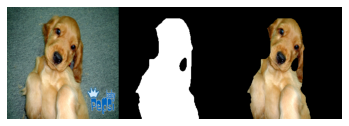

In [45]:
plt.axis('off')
img = x[0]
msk = y[0,:,:,1]
msk = np.stack((msk,)*3, axis=-1)

plt.imshow(np.concatenate([img, msk, img*msk], axis=1))

In [46]:
# IoU metric
def mean_iou_binary(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0,1), tf.equal(yp0,1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union,0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [47]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,1]
    yp0 = tf.argmax(y_pred, axis=-1)
    yp0 = K.cast(yp0, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [48]:
def conv_block(x, nKernels=32, kernel_size=3):
    cov = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', use_bias=False, padding='same')(x)
    bn = BatchNormalization()(cov)
    act = Activation('relus')(bn)

    return act

In [49]:
def residual_block(x, nKernels=16, kernel_size=3):
    indentity = x
    BN1 = BatchNormalization()(x)
    Act1 = Activation('relu')(BN1)
    Conv1 = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', use_bias=False, padding='same')(Act1)
    BN2 = BatchNormalization()(Conv1)
    Act2 = Activation('relu')(BN2)
    Conv2 = Conv2D(nKernels, kernel_size, kernel_initializer='he_normal', use_bias=False, padding='same')(Act2)
  
    return Conv2 + indentity

In [50]:
def MNet(sz = (256, 256, 3)):
  # Input layer

  nKernels = 16

  x = Input(sz)
  # (256, 256, 3)
  layer11 = Conv2D(16, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  layer12 = Conv2D(16, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer11)
  layer13 = Concatenate()([layer11, layer12])
  layer14 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer13)

  layer21p = MaxPooling2D()(layer11)
  layer14p = MaxPooling2D()(layer14)
  layer21 = Concatenate()([layer14p, layer21p])
  layer22 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer21)
  layer23 = Concatenate()([layer22, layer14p])
  layer24 = Conv2D(48, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer23)

  layer31p = MaxPooling2D()(layer21p)
  layer24p = MaxPooling2D()(layer24)
  layer31 = Concatenate()([layer24p, layer31p])
  layer32 = Conv2D(48, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer31)
  layer33 = Concatenate()([layer32, layer24p])
  layer34 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer33)

  layer41p = MaxPooling2D()(layer31p)
  layer34p = MaxPooling2D()(layer34)
  layer41 = Concatenate()([layer34p, layer41p])
  layer42 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer41)
  layer43 = Concatenate()([layer42, layer34p])
  layer44 = Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer43)
  layer45 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer44)

  layer45u = UpSampling2D(size=(2,2))(layer45)
  layer35 = Concatenate()([layer34, layer45u])
  layer36 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer35)
  layer37 = Concatenate()([layer36, layer45u])
  layer38 = Conv2D(48, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer37)

  layer38u = UpSampling2D(size=(2,2))(layer38)
  layer25 = Concatenate()([layer24, layer38u])
  layer26 = Conv2D(48, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer25)
  layer27 = Concatenate()([layer26, layer38u])
  layer28 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer27)

  layer28u = UpSampling2D(size=(2,2))(layer28)
  layer15 = Concatenate()([layer14, layer28u])
  layer16 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer15)
  layer17 = Concatenate()([layer16, layer28u])
  layer18 = Conv2D(16, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(layer17)

  layer45u = UpSampling2D(size=(2,2))(layer45)
  layer39 = Concatenate()([layer45u, layer38])
  layer39u = UpSampling2D(size=(2,2))(layer39)
  layer29 = Concatenate()([layer39u, layer28])
  layer29u = UpSampling2D(size=(2,2))(layer29)
  layer19 = Concatenate()([layer29u, layer18])

  last = Conv2D(2, (1,1), kernel_initializer='he_normal', activation='relu', padding='same')(layer19)

  #model creation 
  model = Model(inputs=[x], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [mean_iou])
  
  return model



In [51]:
model = MNet()

In [52]:
# Callbacks
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
    callbacks = [checkpointer, PlotLearning()]
    return callbacks

# PlotLearning 클래스
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        # 랜덤 테스트 이미지 선택 및 전처리
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256,256)))/255.
        raw = raw[:,:,0:3]

        # mask predict
        pred = model.predict(np.expand_dims(raw, 0))

        # mask post-processing
        msk = pred[0]
        msk = np.argmax(msk, axis=-1)

        # pred = (B, W, H, C)
        msk = np.stack((msk,)*3, axis=-1)

        combined = np.concatenate([raw, msk, raw*msk], axis=1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()


In [53]:
# Training
train_steps = len(train_files)
test_steps = len(test_files)
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


KeyboardInterrupt: ignored